# LIBRARY

In [1]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Attention, Input, concatenate, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fasttext

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import contractions
from contractions import contractions_dict

from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hl10a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hl10a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hl10a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
print(tf.config.list_physical_devices('GPU'))


print(tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
))

print(tf.config.experimental.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# LOAD DATASET

In [4]:
path_data = "data/covid/"
data_name = 'covid_articles_raw.csv'

data_raw = pd.read_csv(path_data+data_name)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477551 entries, 0 to 477550
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     477551 non-null  object
 1   content   477548 non-null  object
 2   category  477539 non-null  object
dtypes: object(3)
memory usage: 10.9+ MB


## FILTER

In [5]:
Text = "title"
Label = "category"

data_Clean = data_raw[[Text,Label]].copy().dropna()

data_Clean.rename(columns = {Text:'Text',Label:'Label'}, inplace = True)

data_Clean.info()
data_Clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 477539 entries, 0 to 477550
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    477539 non-null  object
 1   Label   477539 non-null  object
dtypes: object(2)
memory usage: 10.9+ MB


,Text,Label
0,Looking into the truth about modern workplace ...,general
1,Hexo refiles financial statements,general
2,"Japan raid, Turkey arrests in widening Ghosn p...",general
3,Pope's bodyguards criticised over slapping inc...,general
4,Lebanon denies president welcomed fugitive Ghosn,general


## VISUALIZATION

In [6]:
groups = data_Clean.groupby(by='Label').count()['Text']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups.values,
    marker_color='cadetblue',
    width=0.4, 
    text=groups,
    textposition='outside'
))

fig.update_layout(title=f'Số lượng văn bản có trong mỗi lớp của tập COVID News Articles', title_x=0.5,  yaxis=dict(range=[0, 300000]))

fig.show()

In [7]:
large_groups = data_Clean.groupby(by='Label').count()['Text']
groups = large_groups[large_groups > 10000]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups.values,
    marker_color='cadetblue',
    width=0.4, 
    text=groups,
    textposition='outside'
))

fig.update_layout(title=f'Số lượng văn bản có trong mỗi lớp của tập COVID News Articles', title_x=0.5,  yaxis=dict(range=[0, 300000]))

fig.show()

In [8]:
data_text =  data_Clean.loc[data_Clean['Label'].isin(groups.index)].reset_index(drop=True)
# Xóa ký tự '\n'
data_text['Text'] = data_text['Text'].apply(lambda x: x.replace('\n', ' '))

data_text.head()

,Text,Label
0,Looking into the truth about modern workplace ...,general
1,Hexo refiles financial statements,general
2,"Japan raid, Turkey arrests in widening Ghosn p...",general
3,Pope's bodyguards criticised over slapping inc...,general
4,Lebanon denies president welcomed fugitive Ghosn,general


# PRE-PROCESSING

In [9]:
def pre_Processing(data):
  '''
  # Đổi văn bản thô sang văn bản gốc
  Ví dụ:
        He played football while she was playing tennis. The request was denied. He goes to school. She bakes cakes. I'm gonna go to the store
        He play football while she be play tennis . The request be deny . He go to school . She bake cake . I be go to go to the store
  '''
  def lemmatization_and_stemming(text):
    lemmatization =  ' '.join([contractions_dict.get(word, word) for word in text.split()])
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in lemmatization.split()])

  # Hàm loại bỏ stop words
  def remove_stop_words(text):
      # Lấy danh sách stop words tiếng Anh
      stop_words = set(stopwords.words('english'))
      words = text.split()
      filtered_words = [word for word in words if word not in stop_words]
      return ' '.join(filtered_words)
  
  # đưa các từ viết tắt về nguyên mẫu
  data['Text'] = data['Text'].apply(lemmatization_and_stemming)

  # đưa về chữ thường
  data['Text'] = data['Text'].str.lower()
  
  # loại bỏ ký tự đặc biệt và số
  data['Text'] = data['Text'].apply(lambda x: re.sub('[^a-z]', ' ', str(x)))

  # Xóa từ dừng
  data['Text'] = data['Text'].apply(remove_stop_words)
  # loại các text null
  data = data[data['Text'] != ""]

  return data[['Text', 'Label']]

data_processing = pre_Processing(data_text)

name_data_processing = "covid_processing.csv"
# Xuất DataFrame thành file .csv
data_processing.to_csv(path_data + name_data_processing, index=False, encoding='utf-8')

data_processing.info()
data_processing.head()

<class 'pandas.core.frame.DataFrame'>
Index: 467328 entries, 0 to 467397
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    467328 non-null  object
 1   Label   467328 non-null  object
dtypes: object(2)
memory usage: 10.7+ MB


,Text,Label
0,looking truth modern workplace environments,general
1,hexo refiles financial statements,general
2,japan raid turkey arrest widen ghosn probe,general
3,pope bodyguards criticise slap incident,general
4,lebanon deny president welcome fugitive ghosn,general


In [10]:
data_sample = data_processing.copy()
data_sample["length"] = data_sample["Text"].apply(lambda x: len(x.split()))
data_sample["length"].describe()

count    467328.000000
mean          8.156122
std           2.728957
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max         259.000000
Name: length, dtype: float64

# Tokenizer

In [11]:
name_data_processing = "covid_processing.csv"
data_processing = pd.read_csv(path_data + name_data_processing).sample(n=200000, replace=False)

data_tokenizer = data_processing.copy()
# Tách từ
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)

data_tokenizer.info()
data_tokenizer.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 35170 to 117323
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    200000 non-null  object
 1   Label   200000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


,Text,Label
35170,"[first, quarter, earnings, could, ugly, charts...",business
173511,"[noida, arrested, vehicles, challaned, flout, ...",business
56884,"[geraint, thomas, way, nhs, zwift, fundraiser,...",general
434728,"[greenbrier, reports, first, quarter, results,...",business
394440,"[children, attend, self, learning, class, home...",general


In [12]:
data_sample = data_tokenizer.copy()
data_sample["length"] = data_sample["Text"].apply(lambda x: len(x))
data_sample["length"].describe()

count    200000.000000
mean          8.152980
std           2.761057
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max         259.000000
Name: length, dtype: float64

In [11]:
# name_data_processing = "data/covid_processing.csv"
# data_processing = pd.read_csv(name_data_processing)
# data_tokenizer = data_processing.copy()

# # Tách từ
# data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)
# # Xuất DataFrame thành file .csv
# data_tokenizer.to_csv("data/covid_tokenizer.csv", index=False, encoding='utf-8')
# data_tokenizer.info()
# data_tokenizer.head()

In [ ]:
# import ast

# selected_df = pd.read_csv("data/covid_tokenizer.csv",  converters={'Text': ast.literal_eval})

# number_per = 80000
# # Khởi tạo danh sách để lưu trữ văn bản đã chọn
# data_tokenizer = pd.DataFrame(columns=['Text', 'Label'])

# for Label in selected_df["Label"].unique():
#     label_indices = selected_df[selected_df['Label'] == Label].index

     
#     # Lấy mẫu ngẫu nhiên từ các chỉ mục thuộc nhãn hiện tại
#     selected_indices = np.random.choice(label_indices, size=min(number_per, len(label_indices)), replace=False)
    
#     # Thêm các dòng đã chọn vào DataFrame mới
#     data_tokenizer = pd.concat([data_tokenizer, selected_df.loc[selected_indices]])

# data_tokenizer.info()

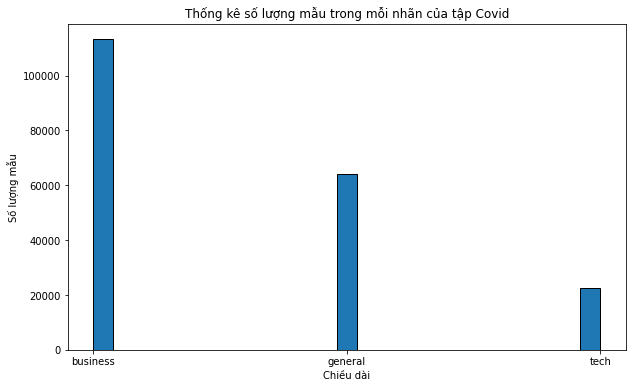

In [13]:
# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(data_tokenizer["Label"].values, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Thống kê số lượng mẫu trong mỗi nhãn của tập Covid')
plt.xlabel('Chiều dài')
plt.ylabel('Số lượng mẫu')
plt.show()

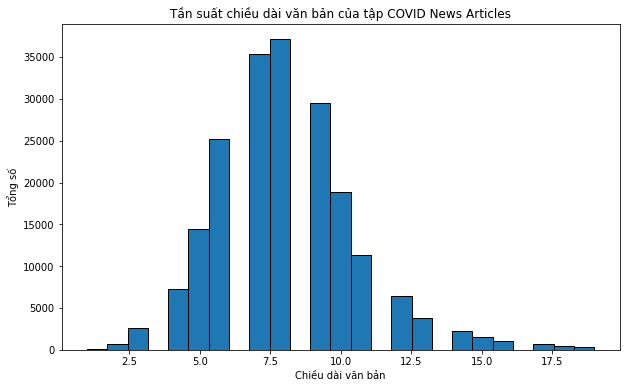

In [14]:
lenght = []
for i in data_tokenizer["Text"].values:
    if len(i) < 20:
        lenght.append(len(i))

# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(lenght, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Tần suất chiều dài văn bản của tập COVID News Articles')
plt.xlabel('Chiều dài văn bản')
plt.ylabel('Tổng số')
plt.show()

In [15]:
max_length = 30

def tokenization(data):
    Text_col = data["Text"]
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1
    
    # chuyển đổi dữ liệu văn bản thành các chuỗi số 
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài 
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer)

# Word Embedding - FastText

In [16]:
with open('data/fasttext/text_covid.txt', 'w') as file:
    # Write content to the 
    for i in data_processing["Text"]:
        file.write(i+"\n")

# Training the fastText classifier
model = fasttext.train_unsupervised('data/fasttext/text_covid.txt', maxn=0, dim=100)
model.save_model('model/fasttext/covid_fasttext_100d.bin')

In [18]:
ft = fasttext.load_model('model/fasttext/covid_fasttext_100d.bin')
embed_vector_size = ft.get_word_vector("you").shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size, 
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 30
input_dim  | vocab_size        = 65317
output_dim | embed_vector_size = 100
weights = (65317, 100)


# Model

In [94]:
def create_model(labels, LSTM_layers, hidden_layers):
    model = Sequential()
    model.add(embedding)
    
    for i in range(LSTM_layers):
        model.add(LSTM(hidden_layers, return_sequences=True))

    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(labels, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

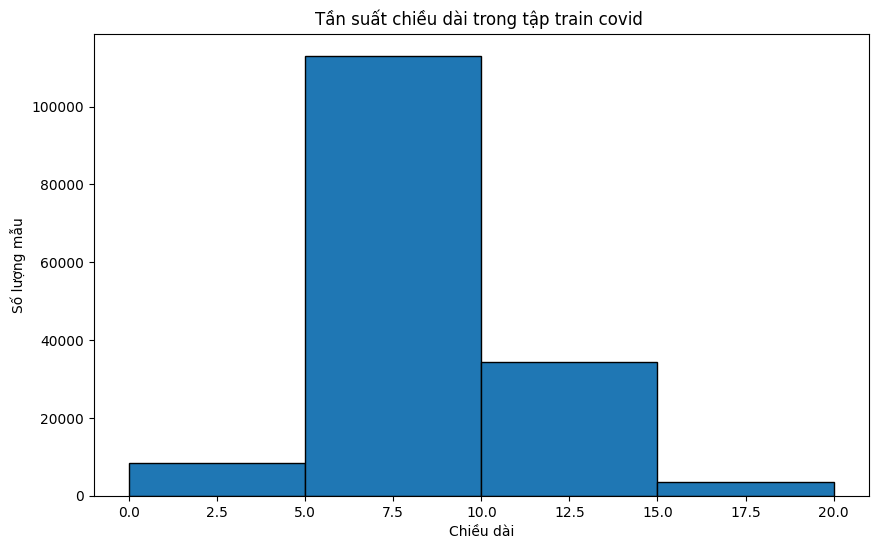

In [95]:
# Chia dataset thành tập training thành train_val và test
X_train_val, X_test = train_test_split(data_tokenizer["Text"], test_size=0.2, random_state=40)

lengths = []
for i in X_train_val:
    lengths.append(len(i))
# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(lengths, bins=[0, 5, 10, 15, 20], edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Tần suất chiều dài trong tập train covid ')
plt.xlabel('Chiều dài')
plt.ylabel('Số lượng mẫu')
plt.show()

# Labels

In [96]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Label"].values)
print('\nLabels:',list(label_encoder.classes_), '\n')

def encode_label(label):
    return label_encoder.transform(label)

def decode_label(label):
    return label_encoder.inverse_transform(label)


Labels: ['business', 'general', 'tech'] 



# Train_Test_Validation split 

In [114]:
# Chia dataset thành tập training thành train_val và test
X_train_val, X_test, y_train_val, y_test = train_test_split(data_tokenizer_pad, data_tokenizer["Label"].values, test_size=0.2, random_state=40)

# encode label
y_train_val =  encode_label(y_train_val)
y_test =  encode_label(y_test)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)

Size Train:  (120000, 30) (120000,)
Size Test:  (40000, 30) (40000,)
Size Validation:  (40000, 30) (40000,)


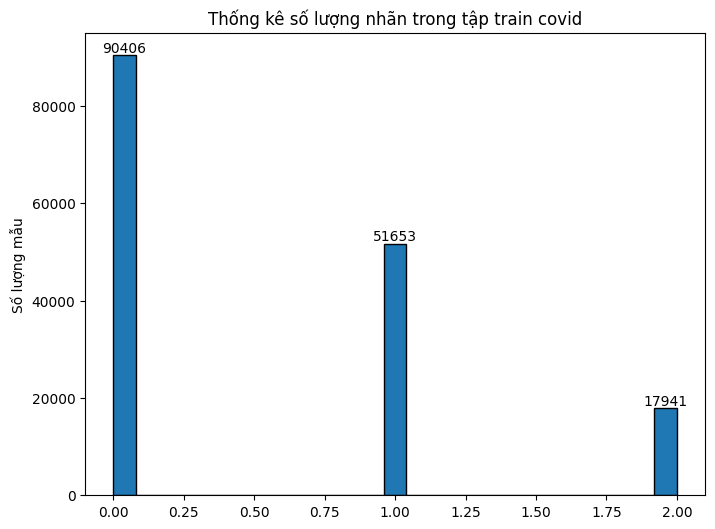

In [98]:
# Đặt kích thước của hình vẽ
plt.figure(figsize=(8, 6))

# Vẽ biểu đồ tần suất
hist, bins, _ = plt.hist(y_train_val, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram

# Thêm số liệu lên đầu của từng cột (loại bỏ số liệu nếu giá trị là 0)
for i in range(len(hist)):
    if hist[i] != 0:
        plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),
                 ha='center', va='bottom')

plt.title('Thống kê số lượng nhãn trong tập train covid')
plt.ylabel('Số lượng mẫu')
plt.show()

# Run

In [101]:
batchSize = round(X_train.shape[0] * 0.085)
batchSize

10200

In [102]:
lstm_layers = 3
classes = data_tokenizer['Label'].nunique()
hidden_layers = 100

model = create_model(classes, lstm_layers, hidden_layers)
batchSize = round(X_train.shape[0] * 0.085)
epoch = 20
print("batchSize =", batchSize)
model.summary()

batchSize = 10200
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           5922600   
                                                                 
 lstm_17 (LSTM)              (None, 20, 100)           80400     
                                                                 
 lstm_18 (LSTM)              (None, 20, 100)           80400     
                                                                 
 lstm_19 (LSTM)              (None, 20, 100)           80400     
                                                                 
 seq_self_attention_6 (SeqS  (None, 20, 100)           6465      
 elfAttention)                                                   
                                                                 
 flatten_6 (Flatten)         (None, 2000)              0         
                                    

In [103]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()

lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/20
12/12 [==============================] - 314s 26s/step - loss: 0.9512 - accuracy: 0.5528 - val_loss: 0.8717 - val_accuracy: 0.5663
Epoch 2/20
12/12 [==============================] - 295s 25s/step - loss: 0.8354 - accuracy: 0.5926 - val_loss: 0.8028 - val_accuracy: 0.6135
Epoch 3/20
12/12 [==============================] - 271s 23s/step - loss: 0.7859 - accuracy: 0.6266 - val_loss: 0.7771 - val_accuracy: 0.6311
Epoch 4/20
12/12 [==============================] - 275s 23s/step - loss: 0.7670 - accuracy: 0.6378 - val_loss: 0.7656 - val_accuracy: 0.6364
Epoch 5/20
12/12 [==============================] - 299s 25s/step - loss: 0.7568 - accuracy: 0.6444 - val_loss: 0.7575 - val_accuracy: 0.6400
Epoch 6/20
12/12 [==============================] - 290s 24s/step - loss: 0.7496 - accuracy: 0.6482 - val_loss: 0.7510 - val_accuracy: 0.6439
Epoch 7/20
12/12 [==============================] - 277s 23s/step - loss: 0.7427 - accuracy: 0.6534 - val_loss: 0.7455 - val_accuracy: 0.6468
Epoch 

In [104]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1250/1250 [==============================] - 59s 47ms/step - loss: 0.6808 - accuracy: 0.6893
Test Score: 0.6808232665061951
Test Accuracy: 0.6893249750137329


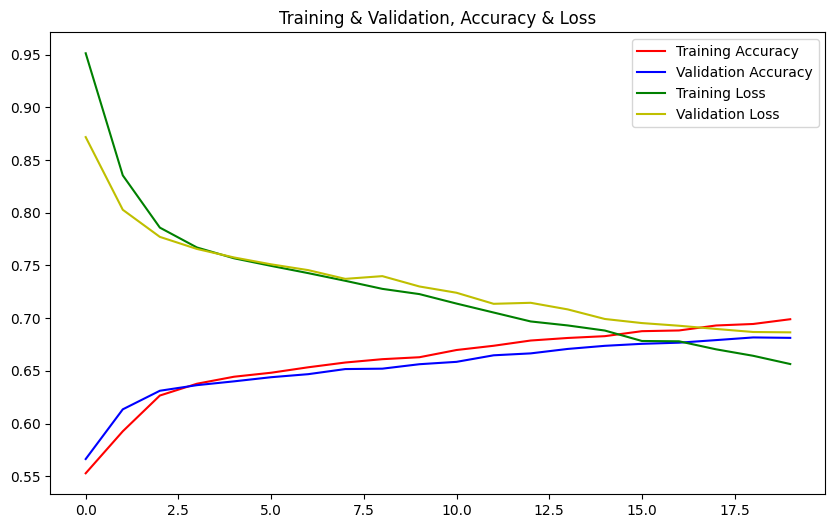

In [105]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    
    plt.title('Training & Validation, Accuracy & Loss')
    plt.legend(loc=0)
    # Lưu biểu đồ vào một tệp tin hình ảnh, ví dụ: "plot.png"
    plt.savefig(f'img/covid_{max_length}_{X_train.shape[0]}_{lstm_layers}_{batchSize}_{epoch}_{training_time}.png')
    plt.show()


plot_graph(lstm_model_history)

In [106]:
path = f"model/covid/covid_{max_length}_{X_train.shape[0]}_{lstm_layers}_{batchSize}_{epoch}_{training_time}.h5"
print(path)
model.save(path)

model/covid/covid_20_120000_3_10200_20_5668.25.h5


c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
path = "model/covid/covid_30_120000_10200_20_9414.22.h5"
# Register the custom object
with tf.keras.utils.custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    model = load_model(path)

# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [115]:

start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")



1250/1250 [==============================] - 103s 81ms/step
Kết quả thực tế: ['business' 'general' 'business' ... 'business' 'general' 'business']
Kết quả mô hình phân loại: ['business' 'tech' 'business' ... 'business' 'business' 'business'] - [ True False  True ...  True False  True]


In [ ]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

In [ ]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class),3)
macro_recall = round(np.mean(recall_per_class),3)
macro_f1 = round(np.mean(f1_per_class),3)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")